# Estimation, Bootstrapping, and Confidence Intervals

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

custom_palette = sns.color_palette('viridis', 2)
sns.set_palette(custom_palette)

## Estimation
How can we estimate an unknown parameter?
Remember that a parameter is a numerical value associated with a population. To figure out the value of a parameter, we need data. If we have the relevant data for the entire population, we can simply calculate the parameter. But usually, we only have access to a sample of the population. 

This leads to a question of inference: How to make justifiable conclusions about the unknown parameter, based on the data in the random sample? 

#### Percentiles
In the following methods, we will use percentiles. 

Numerical data can be sorted in increasing or decreasing order. Thus the values of a numerical data set have a rank order. A percentile is the value at a particular rank.

For example, if your score on a test is on the 95th percentile, a common interpretation is that only 5% of the scores were higher than yours. The median is the 50th percentile; it is commonly assumed that 50% the values in a data set are above the median.

We can compute percentiles using numpy percentile method or the pandas quantile method. 

Note that we need to accurately define percentiles to account for ties (equal values) in the data. 
We can define this using the "interpolation" parameter of the percentile/quantile methods. 

In this course, we will use the following definition:

Let  $p$   be a number between 0 and 100. The $p$th percentile of a collection is the smallest value in the collection that is at least as large as $p$% of all the values. 

To do this, use "method='higher'" in numpy or "interpolation='higher'" in pandas. Note that these are *not* the default options.

In [2]:
test_scores = np.array([100, 92, 97, 83, 67])
print(np.percentile(test_scores, 50, method='higher'))

df = pd.DataFrame({'test_scores': test_scores})
print(df.test_scores.quantile(0.5))

print(np.percentile(test_scores, 70)) # default interpolation
print(np.percentile(test_scores, 70, method='higher')) # our interpolation

# print(df.test_scores.quantile(0.7)) # default interpolation
# print(df.test_scores.quantile(0.7, interpolation='higher')) # our interpolation

92
92.0
96.0
97


### The bootstrap method
Assume we have a random sample from a population and we want to estimate an unknown parameter. We could use the sample to calculate the value of a statistic and use that as our estimate. 

However, we know that our random sample is just one of many possible random samples, and thus our estimate is just one of many plausible estimates.

By how much could those estimates vary? To answer this, it appears we need to draw another sample from the population, and compute a new estimate based on the new sample. But what if we don't have the resources to get another sample?

To address this problem, we will use a clever idea called the bootstrap, which is a clever way to generate new random samples by a method called resampling: the new samples are drawn at random from the original sample.


#### Example: disabilities expanditures
We will use data on disabilities expenditures in California. 

We would like to estimate the median expenditure on people with disabilities. 

In [3]:
disabilities_df = pd.read_csv('disabilities-expenditures-ca.csv')
display(disabilities_df)
disabilities_df.describe()

,Id,Age Cohort,Age,Gender,Expenditures,Ethnicity
0,10210,13--17,17,Female,2113,White not Hispanic
1,10409,22--50,37,Male,41924,White not Hispanic
2,10486,0--5,3,Male,1454,Hispanic
3,10538,18--21,19,Female,6400,Hispanic
4,10568,13--17,13,Male,4412,White not Hispanic
...,...,...,...,...,...,...
995,99622,51 +,86,Female,57055,White not Hispanic
996,99715,18--21,20,Male,7494,Hispanic
997,99718,13--17,17,Female,3673,Multi Race
998,99791,6--12,10,Male,3638,Hispanic


,Id,Age,Expenditures
count,1000.000000,1000.000000,1000.000000
mean,54662.846000,22.800000,18065.786000
std,25643.673401,18.462038,19542.830884
min,10210.000000,0.000000,222.000000
25%,31808.750000,12.000000,2898.750000
50%,55384.500000,18.000000,7026.000000
75%,76134.750000,26.000000,37712.750000
max,99898.000000,95.000000,75098.000000


This is the data on the population. Therefore, we can simply compute the median (and plot the histogram):

population median = 7061


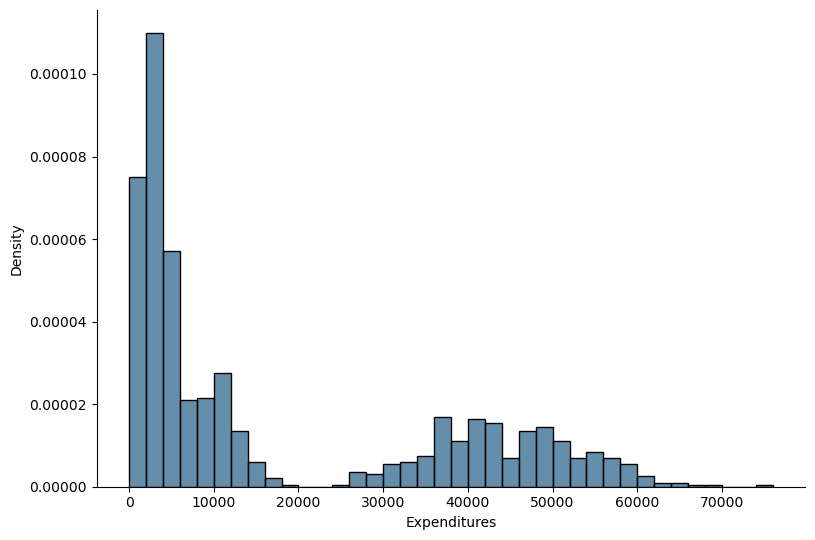

In [4]:
population_median = disabilities_df['Expenditures'].quantile(0.5, interpolation='higher') 
print('population median =', population_median)
ax=sns.displot(disabilities_df, x='Expenditures', bins=np.arange(0, 78000, 2000), height=5.5, aspect=1.5, stat='density')

Now, let's pretend we do not have the population, but only a sample from it, size 180. Let's see how it looks like:

sample median =  5021


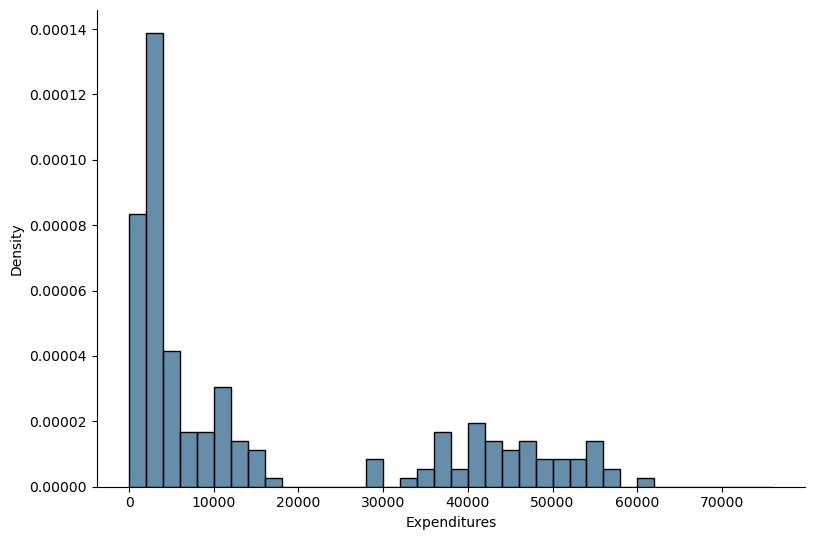

In [5]:
disabilities_sample = disabilities_df.sample(180)
sample_median = disabilities_sample['Expenditures'].quantile(0.5, interpolation='higher')
print('sample median = ', sample_median)
sns.displot(disabilities_sample, x='Expenditures', bins=np.arange(0, 78000, 2000), height=5.5, aspect=1.5, stat='density')

So now we have one estimate of the parameter. But had the sample come out differently, the estimate would have had a different value. We would like to be able to quantify the amount by which the estimate could vary across samples. That measure of variability will help us measure how accurately we can estimate the parameter.

To see how different the estimate would be if the sample had come out differently, we could just draw another sample from the population, but that would be cheating. We are trying to mimic real life, in which we won’t have all the population data at hand.

### The Bootstrap: Resampling from the sample

What we have (and often have in real life) is a **large random sample** from the population. As we know, a large random sample is likely to resemble the population from which it is drawn (you can confirm this in the plots above). This observation allows us to replicate the sampling procedure by **sampling from the sample**.

Here are the steps of the bootstrap method for generating another random sample that resembles the population:

- Treat the original sample _as if_ it were the population.
- Draw from the sample, at random *with replacement*, the same number of times as the original sample size.

It is important to resample the same number of times as the original sample size. The reason is that the variability of an estimate depends on the size of the sample. Since our original sample consisted of 180 people, our sample median was based on 180 values. To see how different the sample could have been, we have to compare it to the median of other samples of size 180.

If we drew 180 times at random _without_ replacement from our sample of size 180, we would just get the same sample back. By drawing with replacement, we create the possibility for the new samples to be different from the original, because some observations might be drawn more than once and others not at all.

Why is this a good idea? By the law of averages, the distribution of the original sample is likely to resemble the population, and the distributions of all the “resamples” are likely to resemble the original sample. So the distributions of all the resamples are likely to resemble the population as well.

Let's look at the distribution we get when resampling from our sample, and the median of this resampled sample:

bootstrapped sample median = 5583


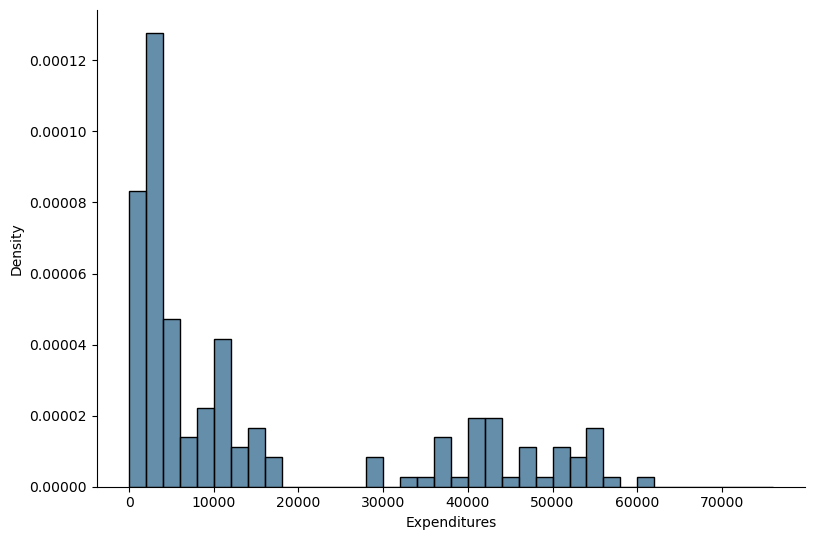

In [6]:
bootstrap_sample = disabilities_sample.sample(180, replace=True) # notice replace = True!
bootstrapped_median = bootstrap_sample['Expenditures'].quantile(0.5, interpolation='higher')
print('bootstrapped sample median =', bootstrapped_median)
sns.displot(bootstrap_sample, x='Expenditures', bins=np.arange(0, 78000, 2000), height=5.5, aspect=1.5, stat='density')

#### Bootstrap an empirical distribution of the sample median
We can do the same exercise, resampling from our one original sample many times, and each time compute the median of this "bootstrapped" sample.

Let us define a function bootstrap_median that takes our original sample, the name of the column containing the variable of interest, and the number of bootstrap samples we want to take, and returns an array of the corresponding resampled medians.

Each time we resample and find the median, we replicate the bootstrap process. So the number of bootstrap samples will be called the number of replications.

In [7]:
def bootstrap_median(original_sample, column_name, num_replications):
    '''This function returns an array of bootstrapped sample medians:
    original_sample: df containing the original sample
    column_name: name of column containing the variable of interest
    num_replications: number of bootstrap samples to draw '''  
    original_sample_size = original_sample.shape[0] # we need to replicate with the same sample size
    original_sample_var_of_interest = original_sample[[column_name]] # the use of [[]] will return a df rather than series
    bstrap_medians = np.empty(num_replications) # collection array for our estimates
    for i in range(num_replications):
        bootstrap_sample = original_sample_var_of_interest.sample(n=original_sample_size, replace=True) # note WITH REPLACEMENT!
        resampled_median = bootstrap_sample.quantile(0.5, interpolation='higher')
        bstrap_medians[i] = resampled_median
    
    return bstrap_medians

# run the bootstrap procedure
medians_bootstrapped = bootstrap_median(disabilities_sample, 'Expenditures', 5000)

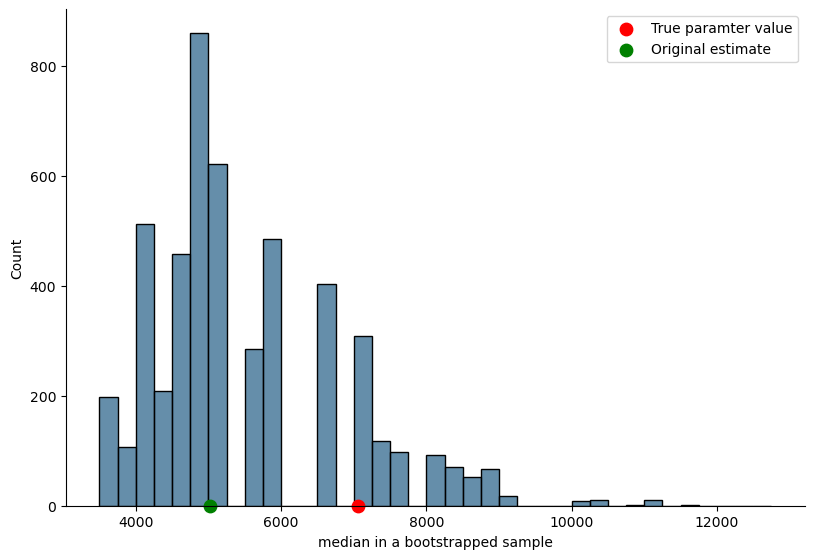

In [8]:
# visualize results
ax = sns.displot(medians_bootstrapped, bins=np.arange(3500, 13000, 250),height=5.5, aspect=1.5)
ax.set(xlabel='median in a bootstrapped sample')
plt.scatter(population_median, 0, color='red', s=80, clip_on=False) # the true value of the parameter (unknowable)
plt.scatter(sample_median, 0, color='green', s=80, clip_on=False) # the original value of the single estimate from the sample
plt.legend(['True paramter value','Original estimate'])

Do the estimates really capture the value of the parameter?

#### Confidence Intervals

We can use the distribution generated by this process of bootstrapping (random sampling from the sample) to give an estimate for the true value of a parameter. By generating many possible samples, we can account for chance variability in the random sample. By providing an interval of estimates instead of just one estimate, we give ourselves some wiggle room.

What interval should we take from this distribution?
One possibility is to take the entire range of the distribution, then we can be fairly confident that the true value of the parameter falls within this interval. 

In [9]:
# estimate the value of the parameter by considering the range of our bootstrap distribution
print('min value: ', np.min(medians_bootstrapped))
print('max value: ', np.max(medians_bootstrapped))

min value:  3203.0
max value:  11629.0


But maybe we want to narrow down the possible values of the parameter further? To do this, we can limit ourselves to different values of percentiles from the distribution we generated, e.g., consider the range between the first and third quartiles. 

In [10]:
# estimate the value of the parameter by considering the 1st and 3rd quartiles
print('lower value: ', np.percentile(medians_bootstrapped, 25, method='higher'))
print('upper value: ', np.percentile(medians_bootstrapped, 75, method='higher'))

lower value:  4710.0
upper value:  6669.0


This narrowed down our estimation of the parameter further. But how confident can we be in our estimation? That is, how confident can we be that our estimated interval indeed covers the **true** value of the parameter (recall this value is unknowable)?

#### Confidence levels

There is a theoretical result (which you can learn in advances statistic classes) that shows that: if our sample is large and random, and we take a confidence interval which includes the middle $p$% of the statistic estimates from our bootstrapped distribution, then there is a probability $p$ that the confidence interval covers the **true** value of the parameter. 

For example, if we take the interval between the 2.5 percentile and the 97.5 percentile, that is, the middle 95% of the distribution, the probability that our estimated interval covers the true value of the parameter is 0.95. This is called a  **95% confidence interval for the parameter**, and this is the interval most commonly used. 

In [11]:
# 95% confidence interval for the expenditures based on our sample
left_end = np.percentile(medians_bootstrapped, 0.5, method='higher')
right_end =  np.percentile(medians_bootstrapped, 99.5, method='higher')
print('lower value: ', left_end)
print('upper value: ', right_end)

lower value:  3702.0
upper value:  10008.0


Let's visualize the confidence interval

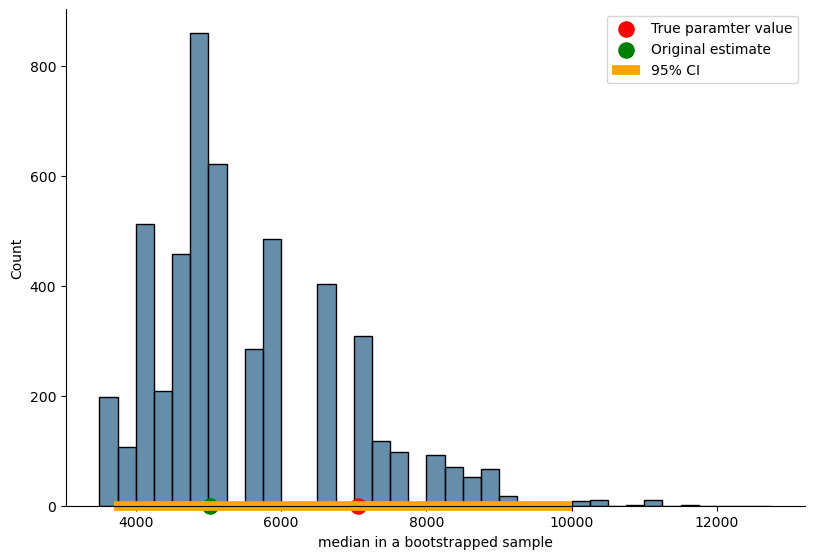

In [12]:
# visualize results
ax = sns.displot(medians_bootstrapped, bins=np.arange(3500, 13000, 250),height=5.5, aspect=1.5)
ax.set(xlabel='median in a bootstrapped sample')
plt.scatter(population_median, 0, color='red', s=120, clip_on=False) # the true value of the parameter (unknowable)
plt.scatter(sample_median, 0, color='green', s=120, clip_on=False) # the original value of the single estimate from the sample
plt.hlines(y=0, xmin=left_end, xmax=right_end, colors='orange', linestyles='solid', lw=7, clip_on=False)  # show line of values between 2.5 and 97.5 percentiles
plt.legend(['True paramter value','Original estimate','95% CI'])


Thought exercise:
If we take a 90% confidence interval, will we get a wider or narrower estimation range compared to a 95% confidence interval? 

Check you answer by modifying the code above.

#### Does the true value of the parameter fall within our confidence intervals?

The “middle 95%” interval of estimates captured the parameter in our example. But were we just lucky?

To see how frequently the interval contains the parameter, we have to run the entire process over and over again. Specifically, we will repeat the following process 100 times:
1. Draw an original sample of size 180 from the population.
2. Carry out 5,000 replications of the bootstrap process and generate the “middle 95%” interval of resampled medians.

We will end up with 100 intervals, and count how many of them contain the population median (which we know only because we just pretend not to know it).

Spoiler alert: The statistical theory of the bootstrap says that the number should be around 95. It may be in the low 90s or high 90s, but not much farther off 95 than that.

In [13]:
# BIG simulation, may take a few minutes

left_ends = []
right_ends = []
median_in_interval = []
for i in range(100):
    disabilities_sample = disabilities_df.sample(180, replace=False) # note: here, sampling from the population
    medians = bootstrap_median(disabilities_sample, 'Expenditures', 5000) # then using the bootstrap method to get confidence interval
    left = np.percentile(medians, 2.5, method='higher')
    left_ends.append(left)
    right = np.percentile(medians, 97.5, method='higher')
    right_ends.append(right)
    median_in_interval.append((population_median < right) and (population_median > left))
    
print('in', np.count_nonzero(median_in_interval), 'of 100 runs of the bootstrap process, the population median was inside the interval')

in 97 of 100 runs of the bootstrap process, the population median was inside the interval


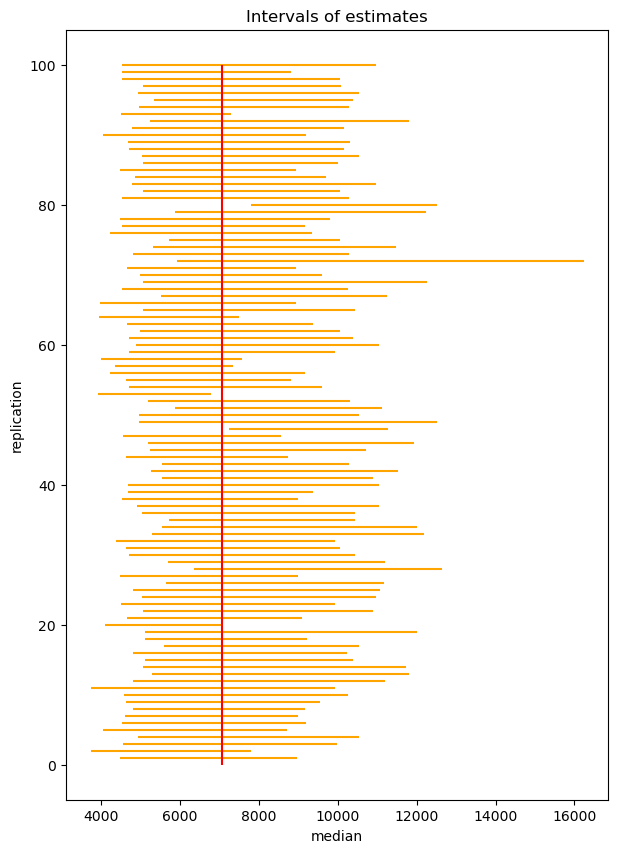

In [14]:
# visualize

fig = plt.figure(figsize=(7,10))
ax = plt.axes()
for i in np.arange(100):
    plt.hlines(i+1, left_ends[i], right_ends[i], colors='orange', linestyles='solid')

plt.vlines(population_median, ymin=0, ymax=i+1, colors='red') # marks the population median
ax.set(xlabel='median', ylabel='replication', title='Intervals of estimates');

In the previous example we saw that our process of estimation produced a good interval about 95% of the time, a “good” interval being one that contains the parameter. We say that we are 95% confident that the process results in a good interval. Our interval of estimates is called a *95% confidence interval for the parameter*, and 95% is called the *confidence level* of the interval.

The situation in the previous example was a bit unusual. Because we happened to know value of the parameter, we were able to check whether an interval was good or a dud, and this in turn helped us to see that our process of estimation captured the parameter about 95 out of every 100 times we used it.

But usually, data scientists don’t know the value of the parameter. That is the reason they want to estimate it in the first place. In such situations, they provide an interval of estimates for the unknown parameter by using methods like the one we have developed. Because of statistical theory and demonstrations like the one we have seen, data scientists can be confident that their process of generating the interval results in a good interval a known percent of the time.

### Confidence interval for a population mean

In this example, we will use the movie dataset from previous lectures. Note that this dataset only contains a **sample** of movies.

We would like to estimate the mean gross income of movies.

In [15]:
movies_df = pd.read_csv('movie_metadata.csv')
display(movies_df.describe())
print(movies_df.shape[0])

,duration,director_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,budget,title_year,imdb_score,movie_facebook_likes
count,3881.000000,3882.000000,3.882000e+03,3.882000e+03,3882.000000,3.882000e+03,3882.000000,3882.000000,3882.000000
mean,109.886369,781.218444,5.114833e+07,1.026713e+05,11281.888717,3.872725e+07,2003.082174,6.462107,9149.570582
std,22.724192,3019.868885,6.984633e+07,1.508444e+05,18941.023800,4.792372e+07,10.007686,1.056180,21324.775147
min,34.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,2.180000e+02,1920.000000,1.600000,0.000000
25%,95.000000,10.000000,6.855627e+06,1.732350e+04,1825.500000,1.000000e+07,1999.000000,5.900000,0.000000
50%,106.000000,58.000000,2.805488e+07,5.040200e+04,3896.500000,2.400000e+07,2005.000000,6.600000,207.500000
75%,120.000000,225.000000,6.548808e+07,1.242370e+05,16006.250000,5.000000e+07,2010.000000,7.200000,11000.000000
max,330.000000,23000.000000,7.605058e+08,1.689764e+06,656730.000000,7.000000e+08,2016.000000,9.300000,349000.000000


3882


Let's see what is our one single estimate for the mean gross income of movies

In [16]:
print(movies_df.gross.mean())

51148333.60329727


Now, we want to compute a 95% confidence interval for the population mean, based on this one sample we have. We will again use the bootstrap. Notice that this time, we do not have access to the actual population mean and therefore we can only hope that our confidence interval will indeed cover the actual unknown value of the parameter (as we saw, this will happen in ~95% of the times)

#### Exercise: 
write a bootstrap_mean method. You can reuse code from the bootstrap_median method.

Use it to estimate the mean gross income from the movies data.

In [17]:
def bootstrap_mean(original_sample, column_name, num_replications):
    '''This function returns an array of bootstrapped sample averages:
    original_sample: df containing the original sample
    column_name: name of column containing the variable of interest
    num_replications: number of bootstrap samples'''


Now, let's say that instead of a 95% confidence interval, we want to get the 80% confidence interval for the mean. 
- Will the interval be wider or narrower?
- Do we need to run the bootstrap process again?
- Do it yourself!

The 80% boostsrap confidence interval for population mean is [49663075.07882535, 52574454.11695003]


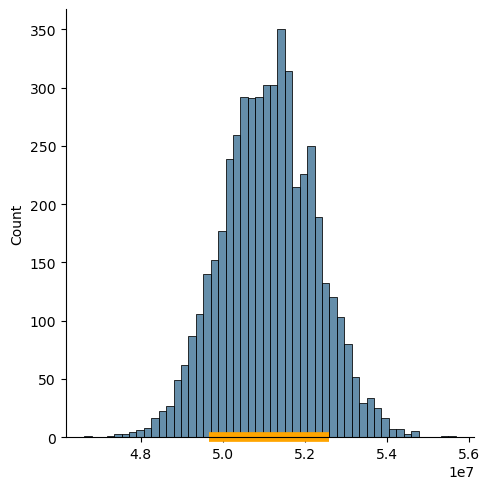

In [20]:
# compute and visualize a 80% confidence interval for the population mean





#### Testing hypotheses using confidence intervals
Confidence intervals give **an estimate to an unknown parameter** based on data in a random sample. 

For example, our approximate 95% confidence interval for the mean gross income of movies goes from (approx.) 49 million dollars to (approx.) 53 million dollars (the exact numbers depend of course on the stochastic bootstrap process). This means that, by our estimate, the mean gross income of movies is somewhere between 49M and 53M, and this estimation process is correct in 95% of the time (assuming our sample is large and random and thus resembles the distribution of the population of movies).

Suppose someone wants to test the following hypotheses:

$H_{0}$: The mean gross income of movies is 55 million dollars.<br>
$H_{1}$: The median gross income of movies is not 55 million dollars.

Then, if you were using the 5% cutoff for the _p_-value, you would reject the null hypothesis. This is because 55M is not in the 95% confidence interval for the population mean. At the 5% level of significance, 55M is not a plausible value for the population mean.

This use of confidence intervals is the result of a duality between confidence intervals and tests: if you are testing whether or not the population mean is a particular value x, and you use the 5% cutoff for the *p*-value, then you will reject the null hypothesis if x is **not** in your 95% confidence interval for the mean.

This can be established by statistical theory. In practice, it just boils down to checking whether or not the value specified in the null hypothesis lies inside the confidence interval.

If you were using the 1% cutoff for the P-value, you would have to check if the value specified in the null hypothesis lies in a 99% confidence interval for the population mean.

### Comparison of groups

So far we only tested hypotheses regarding a single random sample. Often, we would like to compare two random samples to one another. Specifically, we may be interested in knowing if a certain value associated with each of two random samples is the same or are the samples different with respect to that value (this is also sometimes called A/B testing).

As an example, let's check whether there is a difference in the gross income of drama and comedy movies. 


In [21]:
# create a dataframe of comedy and drama movies
drama_comedy_df = movies_df[(movies_df['genres'] == 'Drama') | (movies_df['genres'] == 'Comedy')]
drama_comedy_df.head()

,color,director_name,duration,director_facebook_likes,gross,genres,movie_title,num_voted_users,cast_total_facebook_likes,budget,title_year,imdb_score,movie_facebook_likes
25,Color,James Cameron,194.0,0,658672302,Drama,Titanic,793059,45223,200000000,1997,7.7,26000
49,Color,Baz Luhrmann,143.0,1000,144812796,Drama,The Great Gatsby,362912,29770,105000000,2013,7.3,115000
72,Color,Tom Shadyac,96.0,293,100289690,Comedy,Evan Almighty,115099,108016,175000000,2007,5.4,2000
97,Color,David Fincher,166.0,21000,127490802,Drama,The Curious Case of Benjamin Button,459346,13333,150000000,2008,7.8,23000
113,Color,Francis Lawrence,104.0,508,256386216,Drama,I Am Legend,530870,13076,150000000,2007,7.2,11000


First, let's visualize the means of these two groups:

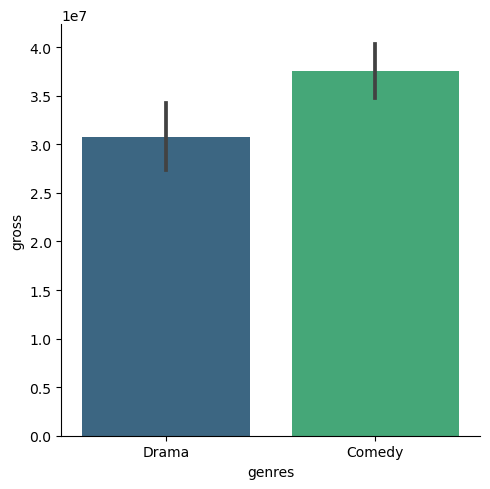

In [22]:
sns.catplot(data=drama_comedy_df, x='genres', y='gross', kind='bar')

So, there is a difference in the averages between the two genres in the sample, but is this difference just due to chance, or is it evidence of a more systamatic difference in the means of the population?

First, let's formulate our hypotheses:

$H_{0}$: The mean gross income of drama movies is equal to the mean gross income of comedy movies<br>
$H_{1}$: The mean gross income of drama movies is **not** equal to the mean gross income of comedy movies

(question: why did we formulate the hypotheses this way and not the other way around?)

We can use the same process of hypothesis testing through confidence intervals to do this. 

To test the hypothesis, we can construct a confidence interval for the **difference between the means** of gross income of drama and comedy movies. That is, the parameter we are interested is the **difference between the means** of drama and comedy movies in the entire population. <br>
We only have a sample of movies, from which we can construct a confidence interval to estimate the difference in means, with high probability. 

*Thought exercise:* What values of the confidence interval will cause us to reject the null hypothesis?

In [23]:
# function that returns the difference in averages
def diff_of_avgs(df, column_name, grouping_var):
    grpby_var = df.groupby(grouping_var)
    avgs = grpby_var[column_name].mean()
#     return avgs.loc['Drama'] - avgs.loc['Comedy']  
    return avgs[1] - avgs[0]

def bootstrap_mean_difference(original_sample, column_name, grouping_var, num_replications):
    '''This function returns an array of bootstrapped differences between two sample averages:
      original_sample: df containing the original sample
      column_name: name of column containing the variable to average
      grouping_var: name of variable according to which to group
      num_replications: number of bootstrap samples'''
    original_sample_size = original_sample.shape[0] # we need to replicate with the same sample size
    original_sample_cols_of_interest = original_sample[[column_name, grouping_var]]
    bstrap_mean_diffs = np.empty(num_replications)
    for i in range(num_replications):
        bootstrap_sample = original_sample_cols_of_interest.sample(original_sample_size, replace=True) # note WITH REPLACEMENT!
        resampled_mean_diff = diff_of_avgs(bootstrap_sample, column_name, grouping_var)
        bstrap_mean_diffs[i] = resampled_mean_diff
    
    return bstrap_mean_diffs

The 95% boostsrap confidence interval for difference between population means [-11113552.90284403, -2374865.042495597]


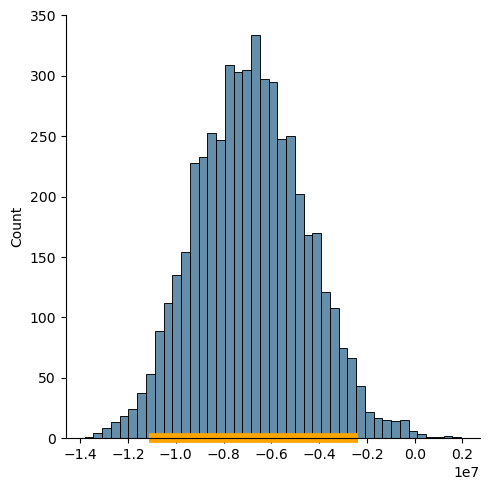

In [24]:
# run the bootstrap procedure
bstrap_diffs = bootstrap_mean_difference(drama_comedy_df, 'gross', 'genres',  5000)

# Get the endpoints of the 95% confidence interval
left_end = np.percentile(bstrap_diffs, 2.5, method='higher')
right_end = np.percentile(bstrap_diffs, 97.5, method='higher')
print('The 95% boostsrap confidence interval for difference between population means', [left_end,right_end])

# visualize results
ax = sns.displot(bstrap_diffs)
plt.hlines(y=0, xmin=left_end, xmax=right_end, colors='orange', linestyles='solid', lw=7, clip_on=False);  # show line of values between 2.5 and 97.5 percentiles

Zero is not included in the 95% CI for the difference between the means, and therefore we reject the null hypothesis and conclude at the 95% confidence level that the there is a difference between the mean gross income of comedy movies and drama movies.

Note that we actually got a more useful result than just saying "the difference is not zero": We have an **estimate of what this difference is**.

#### Another example
We can now compare other features of the two groups we defined. For example, let's compare director_facebook_likes. 
First, visualize the difference:

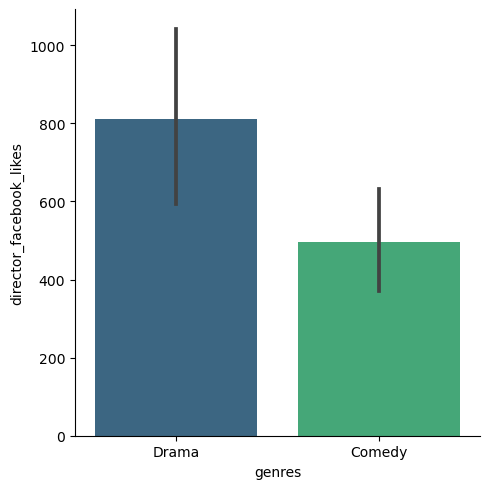

In [25]:
sns.catplot(data=drama_comedy_df, x='genres', y='director_facebook_likes', kind="bar")

##### Exercise
Test the hypothesis that the average number of director Facebook likes for drama movies is different than the average number of director Facebook likes for comedy movies. **Use 0.01 as significance level.**